# Create a QPN matched sub sample from PPMI
    1. Using propensity score matching, including age, sex as covarites to match;
    2. tbd
    
    Visit encoding:

      1. Normal visits:
         'Screening->0',
         'Baseline->1',
         'Month 12->5',
         'Month 24->7',
         'Month 36->9',
         'Month 48->11',

      2. Abnornal visits:
         'Premature Withdrawal->30',
         'Symptomatic Therapy->21',
         'Unscheduled Visit 01->90',
         'Unscheduled Visit 02->91'

In [1]:
from pathlib import Path
import pandas as pd

#PATH
tmp_dir  = Path("/scratch/0tmp") # For privacy, all the PPMI data are stored here locally.
main_dir = Path("/scratch/mr_proc/metadata") # The main GitRepo meta data dir

qpn_file  = main_dir / "qpn"  / "participants.csv" # qpn participants table.
ppmi_file = main_dir / "ppmi" / "participants.csv" # PPMI participants table.
ppmi_all_file = main_dir / "ppmi" / "PPMI_3T_sdMRI_3_07_2022.csv" # The imaging downloading table from livingPark. 

In [2]:
# Known T1 sequence descriptions,copied from heuristics.
T1W_SERIES = [
    'MPRAGE 2 ADNI',
    'MPRAGE ADNI',
    'MPRAGE GRAPPA 2',
    'MPRAGE GRAPPA2',
    'MPRAGE GRAPPA2(adni)',
    'MPRAGE w/ GRAPPA',
    'MPRAGE_GRAPPA',
    'MPRAGE_GRAPPA_ADNI',
    'MPRAGE GRAPPA',
    'SAG T1 3D MPRAGE',
    'sag mprage',
    'MPRAGEadni',
    'MPRAGE GRAPPA_ND',
    '3D SAG',
    'MPRAGE T1 SAG',
    'MPRAGE SAG',
    'SAG T1 3DMPRAGE',
    'SAG T1 MPRAGE',
    'SAG 3D T1',
    'SAG MPRAGE GRAPPA2-NEW2016',
    'SAG MPRAGE GRAPPA_ND',
    'Sag MPRAGE GRAPPA',
    'AXIAL T1 3D MPRAGE',
    'SAG MPRAGE GRAPPA',
    'sT1W_3D_FFE',
    'sT1W_3D_ISO',
    'sT1W_3D_TFE',
    'sag 3D FSPGR BRAVO straight',
    'SAG T1 3D FSPGR',
    'SAG FSPGR 3D '
    'SAG 3D FSPGR BRAVO STRAIGHT',
    'SAG T1 3D FSPGR 3RD REPEAT',
    'SAG FSPGR BRAVO',
    'SAG SPGR 3D',
    'SAG 3D SPGR',
    'FSPGR 3D SAG',
    'SAG FSPGR 3D',
    'SAG 3D FSPGR BRAVO STRAIGHT',
    'SAG FSPGR 3D ',
    't1_mpr_ns_sag_p2_iso',
    'T1',
    'T1 Repeat',
    'AX T1',
    'axial spgr',
    'T1W_3D_FFE AX',
    # added by Vincent
    'AX T1 SE C+',
    '3D SAG T1 MPRAGE',
    '3D SAG T1 MPRAGE_ND',
    '3D T1',
    '3D T1 MPRAGE',
    '3D T1-weighted',
    'Accelerated Sag IR-FSPGR',
    'MPRAGE',
    'MPRAGE - Sag',
    'MPRAGE Phantom GRAPPA2',
    'MPRAGE w/ GRAPPA 2',
    'PPMI_MPRAGE_GRAPPA2',
    'SAG 3D T1 FSPGR',
    'SAG FSPGR 3D VOLUMETRIC T1',
    'Sag MPRAGE GRAPPA_ND',
    'T1-weighted, 3D VOLUMETRIC',
    'tra_T1_MPRAGE',
    '3D T1-weighted_ND', ## added from livingpark
    '3D T1 _weighted',
    'Sagittal 3D Accelerated MPRAGE',
    'T1 REPEAT',
    'MPRAGE Repeat',
    'SAG_3D_MPRAGE'
]
def check_T1(s_):
    res=s_.copy()
    for i in range(len(s_)):
        if s_[i] in T1W_SERIES:
            res[i]=True
        else:
            res[i]=False
    return res

In [3]:
participant_col_sel = ['participant_id', 'age', 'sex', 'group']
metadata_col_sel    = ['Image Data ID', 'Subject', 'Group', 'Sex', 'Age', 'Visit', 'Modality', 'Description']
# harmonizing group label
qpn_group2ppmi_group={'Parkinson':'PD', 'Parkison':'PD', 'Parkinson ':'PD', 'Control ':'Control', 'Control':'Control', 'PD':'PD'};

# data transformation
def group2num(x):
    if x=='PD':
        return 1
    elif x=='Control':
        return 0
    else: # may need some update
        return 0

def sex2num(x):
    if x=='M':
        return 1
    elif x=='F':
        return 0
    else: # may need some update
        return 0

# Read ppmi subjects
ppmi_df  = pd.read_csv(ppmi_file, sep=',', )
ppmi_df=ppmi_df.sort_values(by="participant_id").reset_index(drop=True)
ppmi_df = ppmi_df[(ppmi_df['group']=='PD') | (ppmi_df['group']=='Control')].copy()
ppmi_df.loc[:,'group']=ppmi_df.loc[:,'group'].apply(lambda x: group2num(x))
ppmi_df.loc[:,'sex']  =ppmi_df.loc[:,'sex'].apply(lambda x: sex2num(x))

print('PPMI subject tab info: ', ppmi_df.shape)

# Read qpn subjects
qpn_df  = pd.read_csv(qpn_file, sep=',')
qpn_df=qpn_df.sort_values(by="participant_id").reset_index(drop=True)
qpn_df.loc[:,'group']=qpn_df.loc[:,'group'].apply(lambda x:qpn_group2ppmi_group[x])
qpn_df.loc[:,'group']=qpn_df.loc[:,'group'].apply(lambda x: group2num(x))
qpn_df.loc[:,'sex']  =qpn_df.loc[:,'sex'].apply(lambda x: sex2num(x))

print('QPN subject tab info: ', qpn_df.shape)

# Read ppmi all info
ppmi_all_df = pd.read_csv(ppmi_all_file, sep=',')
ppmi_all_df = ppmi_all_df.loc[:, metadata_col_sel]
# filtering group (PD and Control) and modality (T1)
ppmi_all_df = ppmi_all_df[(ppmi_all_df['Modality']=='MRI') & (check_T1(ppmi_all_df['Description']))].copy()
ppmi_all_df = ppmi_all_df.drop(columns=['Modality', 'Description']).copy()
ppmi_all_df = ppmi_all_df.sort_values(by="Subject").reset_index(drop=True)
ppmi_all_df.columns=['Image ID', 'participant_id', 'group', 'sex', 'age', 'visit'];
ppmi_all_df = ppmi_all_df[(ppmi_all_df['group']=='PD') | (ppmi_all_df['group']=='Control')].copy()
ppmi_all_df.loc[:,'group'] = ppmi_all_df.loc[:,'group'].apply(lambda x: group2num(x))
ppmi_all_df.loc[:,'sex']   = ppmi_all_df.loc[:,'sex'].apply(lambda x: sex2num(x))

# reorder columns
ppmi_all_df=ppmi_all_df.loc[:, ['Image ID', 'participant_id', 'age', 'sex', 'group', 'visit']]
print('PPMI image tab info: ', ppmi_all_df.shape)

PPMI subject tab info:  (395, 4)
QPN subject tab info:  (296, 4)
PPMI image tab info:  (1027, 6)


In [32]:
ppmi_all_df

,Image ID,participant_id,age,sex,group,visit
1,I1493035,100878,66,1,1,1
2,I1493042,100889,75,0,1,1
3,I1493049,100890,78,1,0,1
4,I1497614,100891,62,1,1,1
5,I1496183,100898,76,1,1,1
...,...,...,...,...,...,...
1369,I1119692,71935,65,1,1,1
1370,I1119693,71935,65,1,1,1
1395,I1412792,74817,59,1,1,1
1417,I1196703,75480,56,1,1,1


In [5]:
import seaborn as sns
from psmpy import PsmPy # paper published in 2022 
from psmpy.functions import cohenD
from psmpy.plotting import *

# import relevant libraries
sns.set(rc={'figure.figsize':(10,8)}, font_scale = 1.3)

In [15]:
# setup matching pd_qpn, pd_ppmi
psm.effect_size

,Variable,matching,Effect Size
0,age,before,0.243972
1,age,after,0.136475
2,sex,before,-0.064375
3,sex,after,0.046508


In [6]:
psm_pd = PsmPy(ppmi_df, treatment='group', indx='participant_id', exclude = [])
psm_nc = PsmPy(ppmi_df, treatment='group', indx='participant_id', exclude = [])


In [20]:
psm.logistic_ps(balance=False)

In [30]:
help(psm)

Help on PsmPy in module psmpy.psmpy object:

class PsmPy(builtins.object)
 |  PsmPy(data, treatment, indx, exclude=[], target='outcome')
 |  
 |  Matcher Class -- Match data for an observational study.
 |  Parameters
 |  ----------
 |  data : pd.DataFrame
 |      Data representing the treated group
 |  treatment : str
 |      Column representing the intervention (binary)
 |  indx : str
 |      Name of patient index column
 |  exclude : list (optional)
 |      List of variables to ignore in regression/matching.
 |  target : str (optional)
 |      Outcome variable of interest, will ignore in regression/matching
 |  ----------
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, treatment, indx, exclude=[], target='outcome')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  effect_size_plot(self, title='Standardized Mean differences accross covariates before and after matching', before_color='#FCB754', after_color='#3EC8FB', save=False)
 |      effect

In [26]:
help(psm.knn_matched)
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)

Help on method knn_matched in module psmpy.psmpy:

knn_matched(matcher, replacement=False, caliper=None) method of psmpy.psmpy.PsmPy instance
    knn_matched -- Match data using k-nn algorithm
    Parameters
    ----------
    matcher : str
       string that will used to match - propensity score or proppensity logit
    replacement : bool
       Want to match with or without replacement (default = False)
    caliper : float
       caliper multiplier for allowable matching
    Returns
    matched_ids : pd.DataFrame
        DataFrame with column with matched ID based on k-NN algorithm



/opt/conda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/psmpy/psmpy.py:347: UserWarning: Some values do not have a match
  warnings.warn('Some values do not have a match')


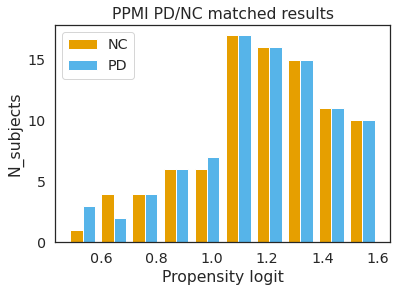

In [27]:
psm.plot_match(Title='PPMI PD/NC matched results', Ylabel='N_subjects', Xlabel= 'Propensity logit',names = ['NC', 'PD'], save=False)

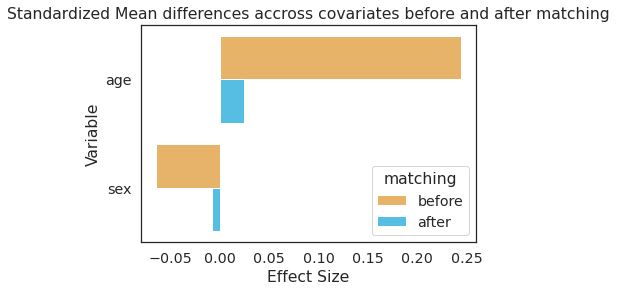

In [28]:
psm.effect_size_plot(save=False)


In [14]:
ppmi_df

,participant_id,age,sex,group
2,100005,53,1,1
3,100006,56,0,1
4,100007,67,1,1
5,100012,66,0,1
6,100018,70,0,1
...,...,...,...,...
553,71978,76,0,1
556,72784,80,0,1
567,74817,59,1,1
577,75480,59,1,1


In [31]:
from causalinference import CausalModel